# Example of data loading with CTA_Analysis

https://gitlab.in2p3.fr/CTA-LAPP/CTA_Analysis

In [1]:
import ctadata as cd
# import ctaplots as cplt
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
from IPython.display import display, Markdown, Latex

In [3]:
%matplotlib inline

In [4]:
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3)
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

### where is your data?

In [5]:
prun_filename = '/Users/thomasvuillaume/Work/CTA/Data/Prun/prod3b/paranal/proton_20deg_0deg_run692___cta-prod3_desert-2150m-Paranal-merged.prun'
psimu_filename = '/Users/thomasvuillaume/Work/CTA/Data/Prun/prod3b/paranal/proton_20deg_0deg_run692___cta-prod3_desert-2150m-Paranal-merged.psimu'

prun contains RAW data  
psimu contains related simulation metadata

In [6]:
prun = cd.load_ctafile(prun_filename)
psimu = cd.load_ctafile(psimu_filename)

In [7]:
print("Size of files:")
print("proton prun: {:.0f} MB".format(os.stat(prun_filename).st_size/1e6))
print("proton psimu: {:.0f} MB".format(os.stat(psimu_filename).st_size/1e6))

Size of files:
proton prun: 177 MB
proton psimu: 53 MB


In [8]:
print("Number of simulated particles = {}".format(len(psimu.tabSimuEvent)))

Number of simulated particles = 2000000


### Simulated particles energy

In [9]:
simuE = np.array([s.energy for s in psimu.tabSimuShower])

/Users/thomasvuillaume/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


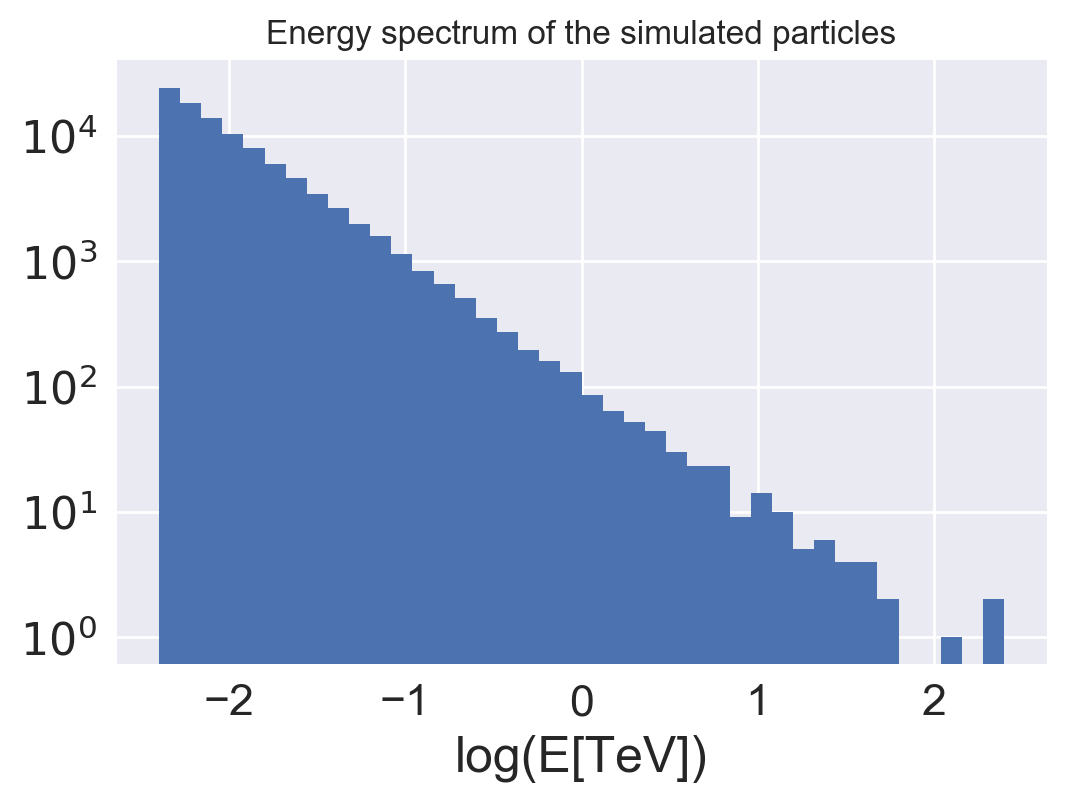

In [10]:
plt.hist(np.log10(simuE), bins = 40)
plt.legend()
plt.xlabel("log(E[TeV])")
plt.title("Energy spectrum of the simulated particles")
plt.yscale('log')
plt.legend()

### Particles incoming direction in the sky

In [11]:
altitude = np.array([ev.altitude for ev in psimu.tabSimuShower])
azimuth = np.array([ev.azimuth for ev in psimu.tabSimuShower])

(1.0215611974911023,
 1.4218401391788194,
 -0.59803870482160559,
 0.59797063631727199)

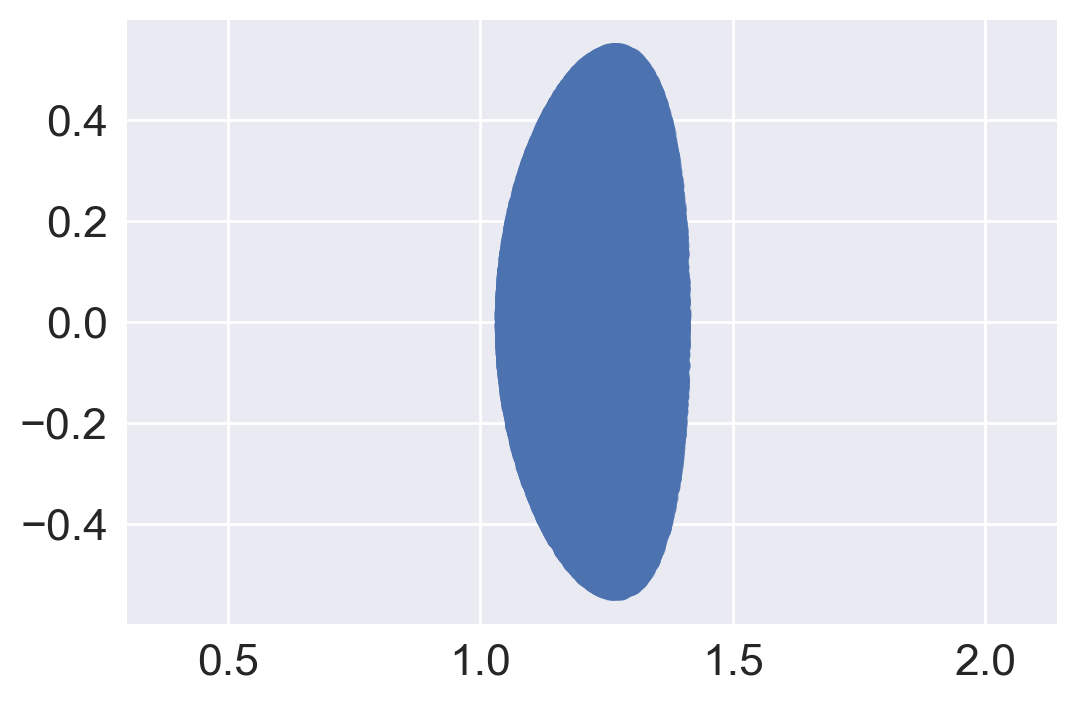

In [12]:
plt.scatter(altitude, azimuth, alpha=0.5)
plt.axis('equal')

### The data is organised per telescope 

In [13]:
print("there are {} telescopes in your file".format(len(prun.tabTelescope)))

there are 567 telescopes in your file


paranal file should contain ~100 telescopes
if your have more, that is because there is no layout applied, so you may choose between several camera type for each telescope position

In [14]:
header = prun.header
telescopes_positions = header.tabPosTel

In [15]:
telescopes_positions

array([[   75.161,     0.   ,    16.   ],
       [  -37.581,    58.117,    16.   ],
       [  -37.581,   -58.117,    16.   ],
       ..., 
       [ 1112.627,  -573.55 ,     5.   ],
       [-1112.627,   573.55 ,     5.   ],
       [-1112.627,  -573.55 ,     5.   ]], dtype=float32)

(-1315.585054479594,
 1315.5850544795937,
 -1261.8129712350715,
 1261.8129712350717)

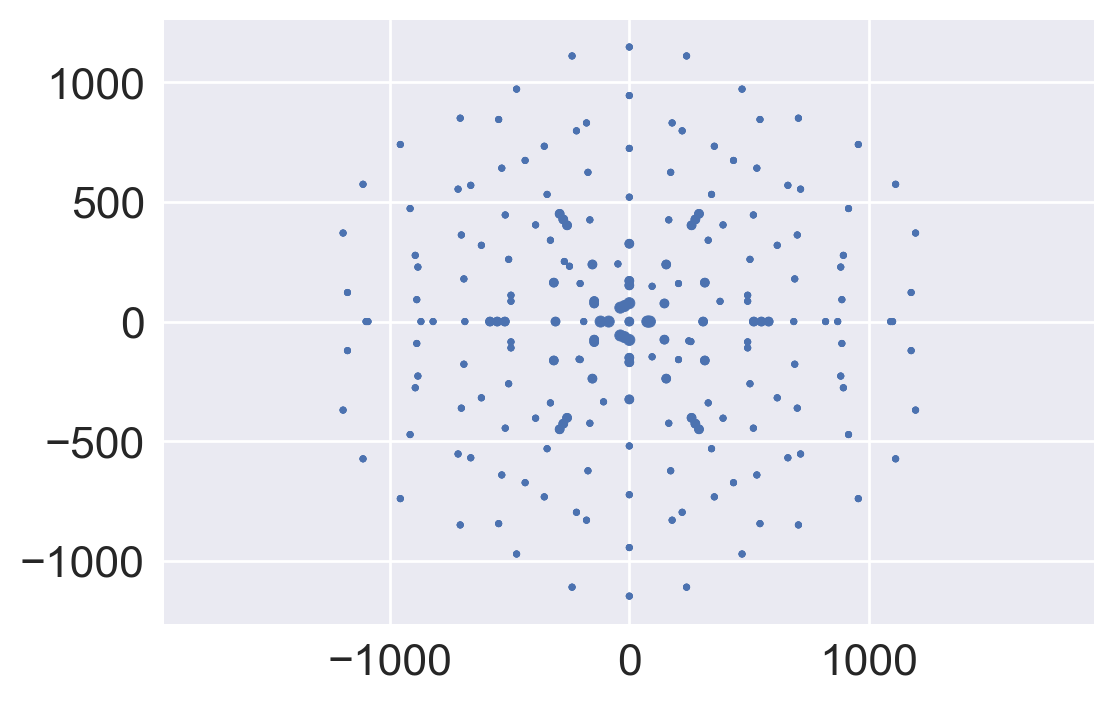

In [16]:
plt.scatter(telescopes_positions[:,0], telescopes_positions[:,1], telescopes_positions[:,2])
plt.axis('equal')

### Let's get some images

Choose one telescope:

In [17]:
tel = prun.tabTelescope[0]

In each telescope, there is a list of events:

In [18]:
tel.tabTelEvent[:4]

Let's pick one event

In [19]:
event = tel.tabTelEvent[13]

In [20]:
print("This is event # {}".format(event.eventId))

This is event # 2137008


Here is the list of pixels values for the high gain channel:

In [21]:
event.tabPixelHi

array([9289, 8644, 8818, ..., 9666, 7975, 8762], dtype=uint32)

To visualise a camera image, one needs the pixels position for this telescope:

In [22]:
pixel_pos = tel.tabPos.tabPixelPosXY
pixel_pos

array([[ 0.075,  1.169],
       [ 0.125,  1.169],
       [-0.05 ,  1.126],
       ..., 
       [ 0.05 , -1.126],
       [-0.125, -1.169],
       [-0.075, -1.169]], dtype=float32)

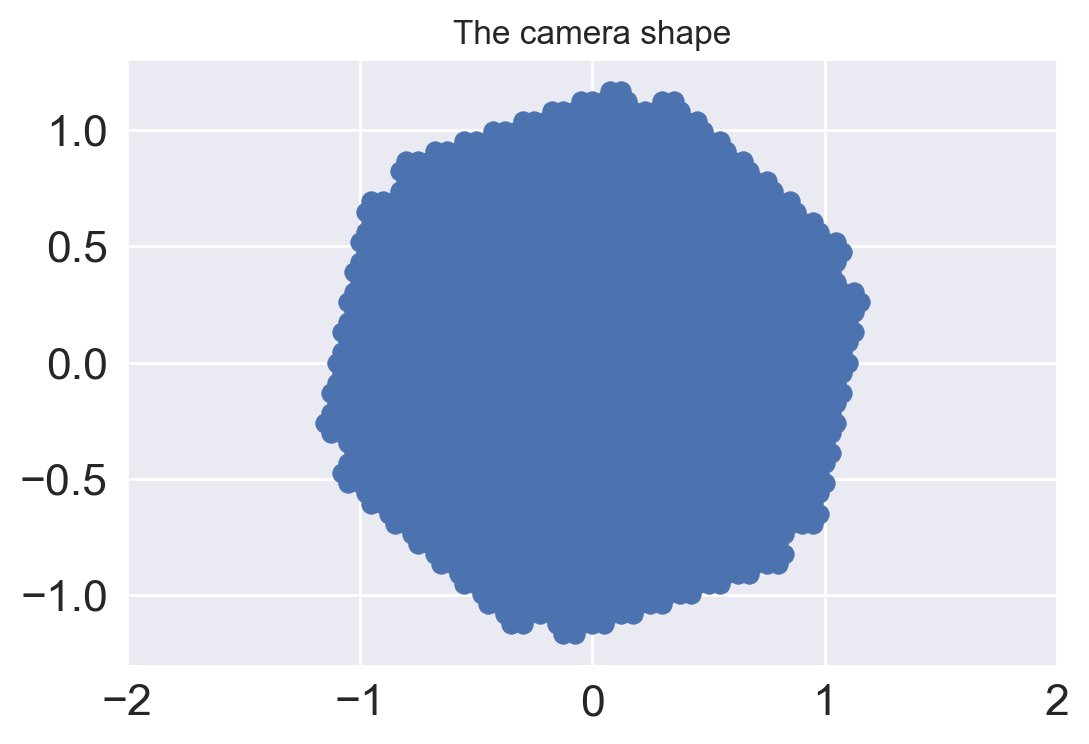

In [23]:
plt.scatter(pixel_pos[:,0], pixel_pos[:,1]);
plt.axis('equal');
plt.title("The camera shape");

Let's image our event:

In [24]:
cm = plt.get_cmap('viridis')

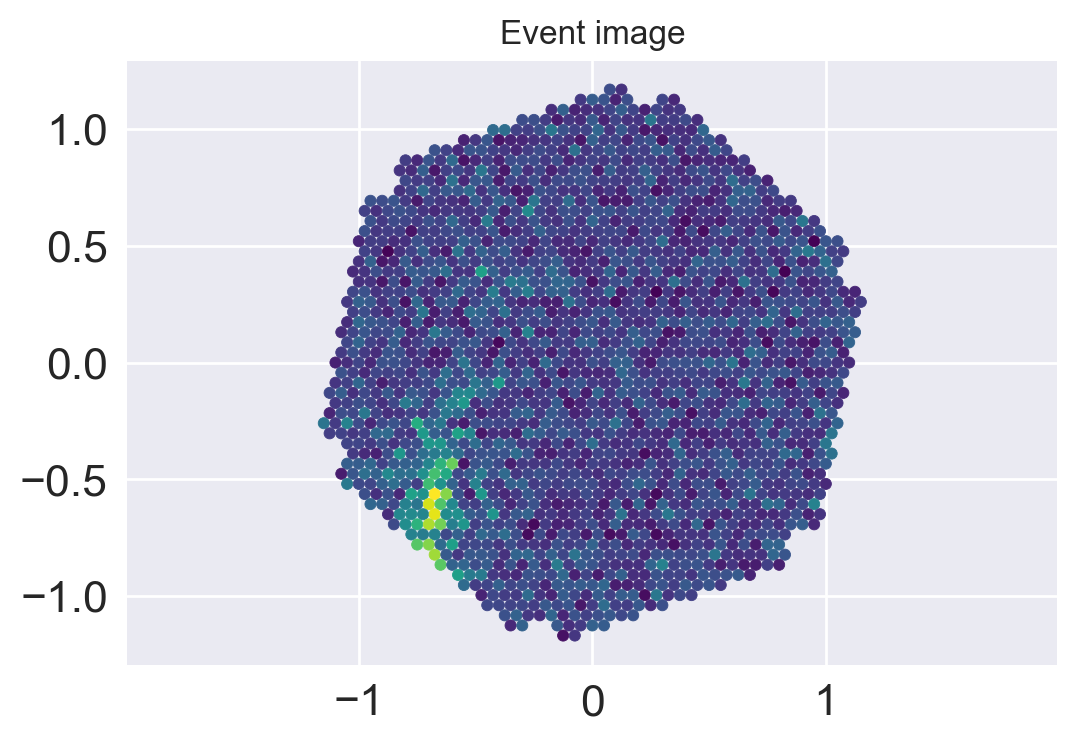

In [31]:
plt.scatter(pixel_pos[:,0], pixel_pos[:,1], c=event.tabPixelHi, cmap=cm, s = 16);
plt.axis('equal');
plt.title("Event image");

If you need pixel transformation

In [32]:
import ctawrapper

we need to reshape the pixel position 2D array to a vector

In [33]:
pixel_pos.reshape(1,len(pixel_pos)*2)[0]

array([ 0.075,  1.169,  0.125, ..., -1.169, -0.075, -1.169], dtype=float32)

In [34]:
injunction_table, column_size, line_size = ctawrapper.createAutoInjunctionTable(pixel_pos.reshape(1,len(pixel_pos)*2)[0])

In [35]:
injunction_table

array([  15,   16,   68, ..., 2956, 3008, 3009], dtype=uint64)

In [36]:
mat = np.zeros((line_size,column_size))

In [37]:
mat

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [38]:
for i in range(len(pixel_pos)):
    index = int(injunction_table[i])
    indexRow = int(index/column_size)
    indexCol = index - int(indexRow*column_size)
    mat[indexRow][indexCol] = event.tabPixelHi[i]

In [39]:
mat

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

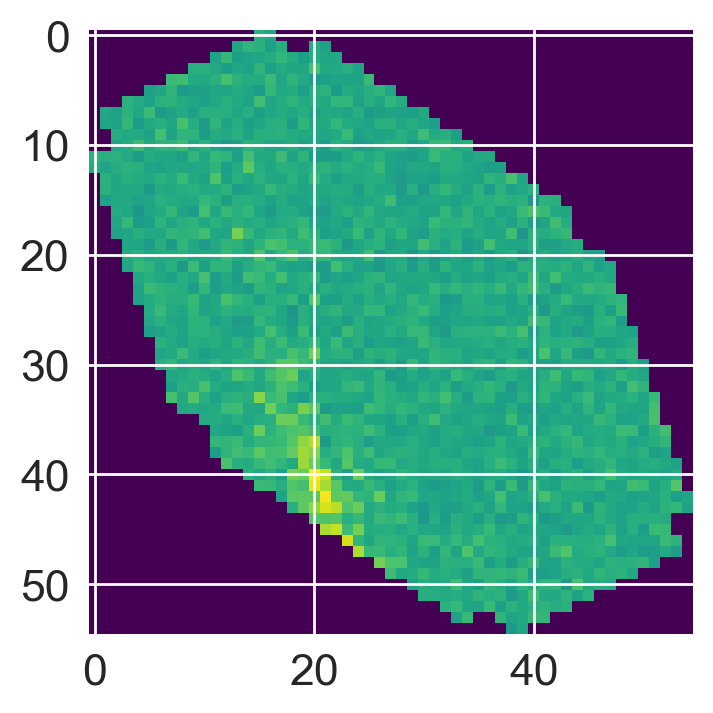

In [42]:
plt.imshow(mat, cmap=cm)

Now, some calibration

In [39]:
import ctacalibration

There is no saturation in the simulations so we set the highest value for 32 bits for now:

In [40]:
saturation_value = 16e6

In [ ]:
ctacalibration.calibrationPRun(prun, saturation_value, saturation_value)

In [ ]:
import ctahillas

In [ ]:
ctahillas.hillas(prun)